In [19]:
# ==========================================================
# PHASE-2 : Multi-Dataset Fine-Tuning (NIH + CheXpert + MIMIC)
# Optimized for low GPU memory and fast turnaround
# ==========================================================
import os, time, random
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np, pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [20]:
# -------------------------
# CONFIG
# -------------------------
class CFG:
    DATASET = "ALL"  # NIH | CHEXPERT | MIMIC | ALL

    NIH_IMAGE_ROOTS = [f"/kaggle/input/data/images_{i:03d}" for i in range(1,13)]
    NIH_CSV = "/kaggle/input/data/Data_Entry_2017.csv"

    CHEXPERT_TRAIN_DIR = "/kaggle/input/chexpert/CheXpert-v1.0-small/train"
    CHEXPERT_VALID_DIR = "/kaggle/input/chexpert/CheXpert-v1.0-small/valid"
    CHEXPERT_TRAIN_CSV = "/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv"
    CHEXPERT_VALID_CSV = "/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv"

    MIMIC_ROOTS = [f"/kaggle/input/mimic-cxr-dataset/official_data_iccv_final/files/p{p}" for p in range(10,20)]
    MIMIC_TRAIN_CSV = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_train.csv"
    MIMIC_VAL_CSV = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_validate.csv"

    BACKBONE = "resnet18"
    SSL_BACKBONE_PATH = "/kaggle/input/phase-1-output-vayishu/ssl_backbone.pt"
    IMAGE_SIZE = 224

    TARGET_COLUMNS = [
        "Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion",
        "Emphysema","Fibrosis","Hernia","Infiltration","Mass","Nodule",
        "Pleural_Thickening","Pneumonia","Pneumothorax"
    ]

    MULTI_LABEL = True
    UNCERTAIN_STRATEGY = "ones"

    # Training schedule
    BATCH_SIZE = 64
    EPOCHS_LINEAR = 5      # smaller for low GPU
    EPOCHS_UNFREEZE = 10
    LR = 1e-4
    WEIGHT_DECAY = 1e-4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CHECKPOINT_DIR = "./phase2_checkpoints"
    SAVE_FINAL = True
    FAST_TRAIN = True
    FAST_TRAIN_MAX = 8000
    NUM_WORKERS = 0

cfg = CFG()
os.makedirs(cfg.CHECKPOINT_DIR, exist_ok=True)
ImageFile.LOAD_TRUNCATED_IMAGES = True
torch.manual_seed(42); np.random.seed(42); random.seed(42)

In [21]:
# ==========================================================
# Dataset Utilities
# ==========================================================
def list_images_in_dirs(dirs: List[str]) -> List[str]:
    exts = {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
    paths = []
    for d in dirs:
        if Path(d).exists():
            paths += [str(p) for p in Path(d).rglob("*") if p.suffix.lower() in exts]
    return sorted(list(dict.fromkeys(paths)))

def prepare_labels_nih(csv_path, roots, target_cols):
    df = pd.read_csv(csv_path)
    df = df[["Image Index","Finding Labels"]].rename(columns={"Image Index":"image_path"})
    def to_vec(s):
        items = [] if pd.isna(s) else [x.strip() for x in s.split("|")]
        return {c:(1.0 if c in items else 0.0) for c in target_cols}
    labs = df["Finding Labels"].apply(to_vec).apply(pd.Series)
    all_paths = list_images_in_dirs(roots)
    name2path = {Path(p).name:p for p in all_paths}
    df["image_path"] = df["image_path"].map(lambda x: name2path.get(x,x))
    return pd.concat([df["image_path"], labs], axis=1)

def prepare_labels_chexpert(train_csv, valid_csv, train_dir, valid_dir, target_cols, uncertain_strategy):
    dfs = []
    for csv,root in [(train_csv,train_dir),(valid_csv,valid_dir)]:
        if not Path(csv).exists(): continue
        df = pd.read_csv(csv)
        img_col = "Path" if "Path" in df.columns else df.columns[0]
        available = [c for c in target_cols if c in df.columns]
        for c in available:
            df[c] = df[c].replace(-1, 1.0 if uncertain_strategy=="ones" else 0.0).fillna(0)
        df["image_path"] = df[img_col].apply(lambda x: str(Path(root)/Path(x).name))
        dfs.append(df[["image_path"]+available])
    out = pd.concat(dfs)
    for c in target_cols:
        if c not in out.columns: out[c]=0.0
    return out

def prepare_labels_mimic(train_csv, val_csv, target_cols):
    dfs=[]
    for csv in [train_csv,val_csv]:
        if Path(csv).exists():
            df=pd.read_csv(csv)
            img_col = "image_path" if "image_path" in df.columns else df.columns[0]
            for c in target_cols:
                if c not in df.columns: df[c]=0.0
            df = df.rename(columns={img_col:"image_path"})
            dfs.append(df[["image_path"]+target_cols])
    return pd.concat(dfs)

# unified ALL
def prepare_label_dataframe_for_cfg():
    ds = cfg.DATASET.upper()
    if ds == "NIH":
        return prepare_labels_nih(cfg.NIH_CSV, cfg.NIH_IMAGE_ROOTS, cfg.TARGET_COLUMNS)
    elif ds == "CHEXPERT":
        return prepare_labels_chexpert(cfg.CHEXPERT_TRAIN_CSV, cfg.CHEXPERT_VALID_CSV, cfg.CHEXPERT_TRAIN_DIR, cfg.CHEXPERT_VALID_DIR, cfg.TARGET_COLUMNS, cfg.UNCERTAIN_STRATEGY)
    elif ds == "MIMIC":
        return prepare_labels_mimic(cfg.MIMIC_TRAIN_CSV, cfg.MIMIC_VAL_CSV, cfg.TARGET_COLUMNS)
    elif ds == "ALL":
        dfs=[]
        try: dfs.append(prepare_labels_nih(cfg.NIH_CSV, cfg.NIH_IMAGE_ROOTS, cfg.TARGET_COLUMNS))
        except: pass
        try: dfs.append(prepare_labels_chexpert(cfg.CHEXPERT_TRAIN_CSV, cfg.CHEXPERT_VALID_CSV, cfg.CHEXPERT_TRAIN_DIR, cfg.CHEXPERT_VALID_DIR, cfg.TARGET_COLUMNS, cfg.UNCERTAIN_STRATEGY))
        except: pass
        try: dfs.append(prepare_labels_mimic(cfg.MIMIC_TRAIN_CSV, cfg.MIMIC_VAL_CSV, cfg.TARGET_COLUMNS))
        except: pass
        if not dfs: raise RuntimeError("No datasets found for ALL mode.")
        df_all = pd.concat(dfs, ignore_index=True)
        return df_all
    else:
        raise ValueError(f"Unsupported DATASET {cfg.DATASET}")

In [22]:
# ==========================================================
# Dataset Class
# ==========================================================
train_tf = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE,cfg.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE,cfg.IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class XrayDataset(Dataset):
    def __init__(self, df, tf):
        self.df=df.reset_index(drop=True)
        self.tf=tf
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        path=row["image_path"]
        if not Path(path).exists():
            return torch.zeros(3,cfg.IMAGE_SIZE,cfg.IMAGE_SIZE), torch.zeros(len(cfg.TARGET_COLUMNS))
        img=Image.open(path).convert("RGB")
        img=self.tf(img)
        y=torch.tensor(row[cfg.TARGET_COLUMNS].values.astype(np.float32))
        return img,y

In [23]:
# ==========================================================
# Model
# ==========================================================
def build_backbone_and_head():
    backbone=models.resnet18(weights=None)
    feat_dim=backbone.fc.in_features
    backbone.fc=nn.Identity()
    if Path(cfg.SSL_BACKBONE_PATH).exists():
        state=torch.load(cfg.SSL_BACKBONE_PATH,map_location="cpu")
        try:
            backbone.load_state_dict(state,strict=False)
            print("[INFO] Loaded Phase-1 backbone weights (partial load allowed).")
        except: print("[WARN] Could not load all weights.")
    for p in backbone.parameters(): p.requires_grad=False
    head=nn.Sequential(
        nn.Linear(feat_dim, feat_dim//2),
        nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(feat_dim//2, len(cfg.TARGET_COLUMNS))
    )
    model=nn.Module()
    model.backbone=backbone
    model.head=head
    return model

In [24]:
# ==========================================================
# 🧠 Training + Eval Utilities
# ==========================================================
def compute_auc(y_true,y_prob):
    aucs={}
    for i,c in enumerate(cfg.TARGET_COLUMNS):
        try: aucs[c]=roc_auc_score(y_true[:,i],y_prob[:,i])
        except: aucs[c]=np.nan
    return aucs

def expected_calibration_error(y_true,y_prob,n_bins=10):
    eces=[]
    for i in range(y_true.shape[1]):
        prob,truth=y_prob[:,i],y_true[:,i]
        bins=np.linspace(0,1,n_bins+1)
        bin_idx=np.digitize(prob,bins)-1
        ece=0.0
        for b in range(n_bins):
            mask=bin_idx==b
            if mask.sum()==0: continue
            acc=truth[mask].mean()
            conf=prob[mask].mean()
            ece+= (mask.sum()/prob.shape[0])*abs(acc-conf)
        eces.append(ece)
    return float(np.nanmean(eces))

def train_one_epoch(model,loader,opt,crit,device):
    model.train();loss_sum=0;n=0
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        z=model.backbone(x);logits=model.head(z)
        loss=crit(logits,y)
        opt.zero_grad();loss.backward();opt.step()
        loss_sum+=loss.item()*x.size(0);n+=x.size(0)
    return loss_sum/n

@torch.no_grad()
def evaluate(model,loader,device):
    model.eval();preds=[];targets=[]
    for x,y in loader:
        x=x.to(device);logits=model.head(model.backbone(x))
        preds.append(logits.sigmoid().cpu().numpy())
        targets.append(y.numpy())
    return np.concatenate(targets),np.concatenate(preds)

In [25]:
# ==========================================================
# MAIN FLOW
# ==========================================================
print(f"[INFO] Preparing labels for dataset: {cfg.DATASET}")
df = prepare_label_dataframe_for_cfg()

# --- Sanitize image paths ---
df["image_path"] = df["image_path"].astype(str)
df = df[~df["image_path"].str.lower().isin(["nan", "none", "null", ""])]
df = df[df["image_path"].str.contains("/", regex=False)]
df = df.reset_index(drop=True)
print(f"[INFO] After sanitizing image paths: {len(df):,} valid rows remain.")

# --- Optional fast mode ---
if cfg.FAST_TRAIN:
    df = df.sample(n=min(cfg.FAST_TRAIN_MAX, len(df)), random_state=42).reset_index(drop=True)
    print(f"[INFO] FAST_TRAIN active → using {len(df):,} samples.")

# --- Split train/val ---
n = len(df)
train_df, val_df = df.iloc[:int(0.8 * n)], df.iloc[int(0.8 * n):]
print(f"[INFO] Train={len(train_df):,} | Val={len(val_df):,}")

# --- Dataloaders ---
train_loader = DataLoader(XrayDataset(train_df, train_tf),
                          batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS)
val_loader = DataLoader(XrayDataset(val_df, val_tf),
                        batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS)

# --- Model, Loss, Optimizer ---
model = build_backbone_and_head().to(cfg.DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.head.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)

# --- Initialize metric history ---
history = {"train_loss": [], "val_auc": [], "val_ece": []}

[INFO] Preparing labels for dataset: ALL
[INFO] After sanitizing image paths: 335,768 valid rows remain.
[INFO] FAST_TRAIN active → using 8,000 samples.
[INFO] Train=6,400 | Val=1,600
[INFO] Loaded Phase-1 backbone weights (partial load allowed).


In [26]:
# ==========================================================
# Linear-Probe Phase (Frozen Backbone)
# ==========================================================
print(f"[INFO] Linear-Probe Training ({cfg.EPOCHS_LINEAR} epochs)")

for ep in range(1, cfg.EPOCHS_LINEAR + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)
    y_true, y_prob = evaluate(model, val_loader, cfg.DEVICE)
    auc = np.nanmean(list(compute_auc(y_true, y_prob).values()))

    history["train_loss"].append(train_loss)
    history["val_auc"].append(auc)
    print(f"[LINEAR] Ep{ep:02d}/{cfg.EPOCHS_LINEAR} | loss={train_loss:.4f} | val_auc={auc:.4f} | {time.time() - t0:.1f}s")

[INFO] Linear-Probe Training (5 epochs)
[LINEAR] Ep01/5 | loss=0.2447 | val_auc=0.2831 | 78.6s
[LINEAR] Ep02/5 | loss=0.0787 | val_auc=0.6812 | 78.7s
[LINEAR] Ep03/5 | loss=0.0669 | val_auc=0.8390 | 77.6s
[LINEAR] Ep04/5 | loss=0.0626 | val_auc=0.8640 | 77.8s
[LINEAR] Ep05/5 | loss=0.0601 | val_auc=0.8691 | 78.7s


In [27]:
# ==========================================================
# Fine-Tuning Phase (Unfreeze last residual block)
# ==========================================================
print(f"[INFO] Fine-Tuning ({cfg.EPOCHS_UNFREEZE} epochs, layer4 unfrozen)")
for name, p in model.backbone.named_parameters():
    if "layer4" in name:
        p.requires_grad = True

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=cfg.LR / 5,
    weight_decay=cfg.WEIGHT_DECAY
)

for ep in range(1, cfg.EPOCHS_UNFREEZE + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)
    y_true, y_prob = evaluate(model, val_loader, cfg.DEVICE)
    auc = np.nanmean(list(compute_auc(y_true, y_prob).values()))
    ece = expected_calibration_error(y_true, y_prob)

    history["train_loss"].append(train_loss)
    history["val_auc"].append(auc)
    history["val_ece"].append(ece)

    print(f"[FT] Ep{ep:02d}/{cfg.EPOCHS_UNFREEZE} | loss={train_loss:.4f} | val_auc={auc:.4f} | ECE={ece:.4f} | {time.time() - t0:.1f}s")

[INFO] Fine-Tuning (10 epochs, layer4 unfrozen)
[FT] Ep01/10 | loss=0.0579 | val_auc=0.8778 | ECE=0.0047 | 80.3s
[FT] Ep02/10 | loss=0.0553 | val_auc=0.8783 | ECE=0.0045 | 80.4s
[FT] Ep03/10 | loss=0.0538 | val_auc=0.8844 | ECE=0.0048 | 79.7s
[FT] Ep04/10 | loss=0.0534 | val_auc=0.8885 | ECE=0.0052 | 78.9s
[FT] Ep05/10 | loss=0.0527 | val_auc=0.8895 | ECE=0.0048 | 78.6s
[FT] Ep06/10 | loss=0.0518 | val_auc=0.8939 | ECE=0.0049 | 78.6s
[FT] Ep07/10 | loss=0.0509 | val_auc=0.8905 | ECE=0.0061 | 78.5s
[FT] Ep08/10 | loss=0.0503 | val_auc=0.8941 | ECE=0.0063 | 78.2s
[FT] Ep09/10 | loss=0.0497 | val_auc=0.8910 | ECE=0.0060 | 78.3s
[FT] Ep10/10 | loss=0.0488 | val_auc=0.8911 | ECE=0.0060 | 79.2s


In [28]:
# ==========================================================
# Save Model + Metrics
# ==========================================================
if cfg.SAVE_FINAL:
    save_path = Path(cfg.CHECKPOINT_DIR) / "finetuned_model.pt"
    torch.save({
        "backbone": model.backbone.state_dict(),
        "head": model.head.state_dict(),
        "cfg": cfg.__dict__,
        "history": history
    }, save_path)
    print(f"[INFO] Saved finetuned model → {save_path}")

[INFO] ✅ Saved finetuned model → phase2_checkpoints/finetuned_model.pt


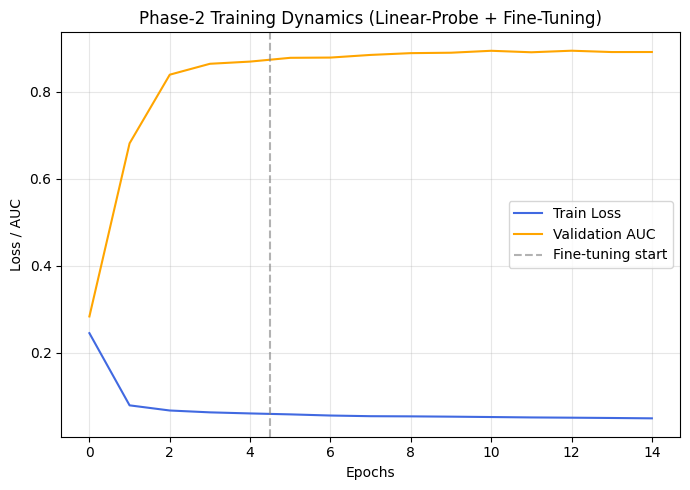

[INFO] Saved → phase2_training_dynamics.png


In [29]:
# ==========================================================
# Visualization (Loss vs AUC)
# ==========================================================
plt.figure(figsize=(7, 5))
plt.plot(history["train_loss"], label="Train Loss", color="royalblue")
plt.plot(history["val_auc"], label="Validation AUC", color="orange")
plt.axvline(x=cfg.EPOCHS_LINEAR - 0.5, linestyle="--", color="gray", alpha=0.6, label="Fine-tuning start")
plt.xlabel("Epochs")
plt.ylabel("Loss / AUC")
plt.title("Phase-2 Training Dynamics (Linear-Probe + Fine-Tuning)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("phase2_training_dynamics.png", dpi=200)
plt.show()
print("[INFO] Saved → phase2_training_dynamics.png")

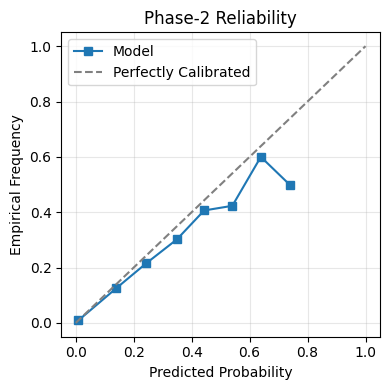

In [30]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, y_prob, n_bins=10, title="Calibration Curve"):
    plt.figure(figsize=(4,4))
    frac_pos, mean_pred = calibration_curve(y_true.ravel(), y_prob.ravel(), n_bins=n_bins)
    plt.plot(mean_pred, frac_pos, "s-", label="Model")
    plt.plot([0,1],[0,1],"--", color="gray", label="Perfectly Calibrated")
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Empirical Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_reliability_diagram(y_true, y_prob, title="Phase-2 Reliability")